# Network Intrusion Detection Using Machine Learning/Deep Learning
This notebook involves the making of machine learning & deep learning models to classify the given data of obtained as a network intrusion into different classes (malignant or benign). Given a sample point, the objective of machine learning model will be to classify that whether the intrusion made is  **Benign** or is a **Malignant** (classify into its specific type).

In [3]:
# ========== STANDARD LIBRARIES ==========
import os
import time
import numpy as np
import pandas as pd

# ========== VISUALIZATION ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== SCIKIT-LEARN (Machine Learning) ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# ========== TENSORFLOW / KERAS (Deep Learning) ==========
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten,
    Bidirectional, LSTM, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    CSVLogger, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


# Check CPU status

In [ ]:
from cpuinfo import get_cpu_info

cpu_info = get_cpu_info()
print("CPU Hardware on Kaggle")
print(f"Brand: {cpu_info['brand_raw']}")
print(f"Architecture: {cpu_info['arch']}")
print(f"Cores (Physical): {cpu_info['count']}")
print(f"Threads (Logical): {cpu_info['count'] * 2 if 'ht' in cpu_info['flags'] else cpu_info['count']}")
print(f"Clock Speed: {cpu_info['hz_advertised_friendly']}")
print(f"Flags (Features): {cpu_info['flags'][:10]}...")  # Shows first 10 CPU features

CPU Hardware on Kaggle
Brand: Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture: X86_64
Cores (Physical): 2
Threads (Logical): 4
Clock Speed: 2.0000 GHz
Flags (Features): ['3dnowprefetch', 'abm', 'adx', 'aes', 'apic', 'arat', 'arch_capabilities', 'avx', 'avx2', 'avx512bw']...


# Check GPU status
In this project I use GPU P100 to accelerate training speed

In [ ]:
# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Mon Nov  3 14:30:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load data from IDS-CIC_IDS2018 dataset
- clean the data and sample from it to create new smaller and balance dataset

## Clean the data and sample from it to create new smaller and balance dataset
- load all data from file paths (this may cause crash due to RAM overflow)
- randomly take 41500 samples from the raw data
- encode ['Label'] column to numeric value
- delete rows which contain inf or non-numeric value
- randomly take 40000 samples from the cleaned data (from top 9 value_counts)
- save to csv file for later use (optional)

In [ ]:
# check the available data
file_paths = []
for root, dirs, filenames in os.walk('/content/kaggle/input/ids-intrusion-csv'):
    for filename in filenames:
        file_paths.append(os.path.join(root, filename))

# Remove specific file if needed
file_to_remove = '/kaggle/input/ids-intrusion-csv/02-20-2018.csv'
if file_to_remove in file_paths:
    file_paths.remove(file_to_remove) # this file is 4.05GB with different shape from the others

print("Number of input files:", len(file_paths))

def load_data(file_paths):
    combined_df = pd.DataFrame()
    for file in file_paths:
        print("Loading:", file)
        try:
            data = pd.read_csv(file, low_memory=False)
            # Combine with other files
            combined_df = pd.concat([combined_df, data], ignore_index=True, copy=False)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue # Skip to the next file

    print("Columns after concatenation:", combined_df.columns) # Print columns for debugging

    if "Timestamp" in combined_df.columns:
        return combined_df.drop(columns=["Timestamp"]) # remove Timestamp because it's irrelevant to the result
    else:
        print("Timestamp column not found. Returning DataFrame without dropping Timestamp.")
        return combined_df

df = load_data(file_paths)

if not df.empty:
    print(df['Label'].value_counts())

    target_values = ['DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Label'] # these targets have too few samples (Label is an error from concatenate data)
    df = df[~df['Label'].isin(target_values)]
    df = df.groupby('Label', group_keys=False).sample(n=41500, random_state=42)

    def clean_data(data):
        encoder = LabelEncoder()
        data['Label'] = encoder.fit_transform(data['Label']) # encode Label (string to number from 0 to 8)
        data = data.apply(pd.to_numeric, errors='coerce') # if error (meet non-numeric value), turn that value into np.nan
        data = data.replace([np.inf, -np.inf], np.nan) # replace inf value (or extreme value) to np.nan
        data = data.dropna()
        return pd.DataFrame(data), encoder
    df, encoder = clean_data(df)
    df = df.groupby('Label', group_keys=False).sample(n=40000, random_state=42)
    # df = pd.DataFrame(df)

    print(df['Label'].unique())
    print(df['Label'].value_counts())

    # Save to output directory
    df.to_csv('/kaggle/working/cleaned_data_sampled.csv', index=False)
else:
    print("DataFrame is empty after loading data.")

Number of input files: 9
Loading: /content/kaggle/input/ids-intrusion-csv/02-21-2018.csv
Loading: /content/kaggle/input/ids-intrusion-csv/02-23-2018.csv
Loading: /content/kaggle/input/ids-intrusion-csv/03-01-2018.csv
Loading: /content/kaggle/input/ids-intrusion-csv/02-16-2018.csv


In [8]:
print("Label encoder mapping:")
for i, label in enumerate(encoder.classes_):
    print(f"{i}: {label}")

Label encoder mapping:


NameError: name 'encoder' is not defined

In [6]:
print("Current working directory:")
print(os.getcwd())

Current working directory:
/content


In [7]:
# -----------------------------------------------------
# Load the already-processed dataset
# -----------------------------------------------------
df = pd.read_csv('/content/kaggle/working/cleaned_data_sampled.csv')

# -----------------------------------------------------
# Recreate the LabelEncoder exactly as original code did
# -----------------------------------------------------
encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Label'])

# Optional: show summary
print("Unique Encoded Labels:", df['Label'].unique())
print(df['Label'].value_counts())

Unique Encoded Labels: [0 1 2 3 4 5 6 7 8]
Label
0    40000
1    40000
2    40000
3    40000
4    40000
5    40000
6    40000
7    40000
8    40000
Name: count, dtype: int64


# Preprocess data for training
- split X and y
- scale value in X to fit in a specific scale
- shuffle and split X and y for train and test purpose (80% for training, 20% for testing)

In [9]:
def preprocess_and_split(data, test_size=0.2, random_state=42):
    # 1) Tách X, y
    X = data.drop('Label', axis=1)
    y = data['Label']                 # y đã là số nhờ LabelEncoder trước đó

    # 2) Chia train/test trước khi fit selector, scaler (tránh leakage)
    X_train, X_test, y_train_ml, y_test_ml = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 3) Fit selector & scaler trên TRAIN, rồi transform cho cả TRAIN/TEST
    selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = selector.fit_transform(X_train)
    X_test_filtered  = selector.transform(X_test)

    scaler = RobustScaler(quantile_range=(5, 95))
    X_train_ml = scaler.fit_transform(X_train_filtered)
    X_test_ml  = scaler.transform(X_test_filtered)

    # 4) Chuẩn bị nhãn cho CNN (one-hot)
    num_classes = int(y.nunique())        # số lớp toàn cục
    y_train_cnn = to_categorical(y_train_ml, num_classes=num_classes)
    y_test_cnn  = to_categorical(y_test_ml,  num_classes=num_classes)

    # 5) Bản 3D cho CNN/LSTM: (N, n_features, 1)
    X_train_cnn = X_train_ml[..., np.newaxis]
    X_test_cnn  = X_test_ml[...,  np.newaxis]

    return (
        X_train_ml, X_test_ml, y_train_ml, y_test_ml,    # 2D cho scikit-learn
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn # 3D + one-hot cho Keras
    )


(
    X_train, X_test, y_train_ml, y_test_ml,      # 2D cho ML models
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn   # 3D cho CNN/LSTM
) = preprocess_and_split(df, test_size=0.2, random_state=42)

print("\nFinal dataset shapes:")
print(f"X_train (ML 2D): {X_train.shape}, y_train_ml: {y_train_ml.shape}")
print(f"X_test  (ML 2D): {X_test.shape},  y_test_ml:  {y_test_ml.shape}")
print(f"X_train_cnn (3D): {X_train_cnn.shape}, y_train_cnn: {y_train_cnn.shape}")
print(f"X_test_cnn  (3D): {X_test_cnn.shape},  y_test_cnn:  {y_test_cnn.shape}")


Final dataset shapes:
X_train (ML 2D): (288000, 67), y_train_ml: (288000,)
X_test  (ML 2D): (72000, 67),  y_test_ml:  (72000,)
X_train_cnn (3D): (288000, 67, 1), y_train_cnn: (288000, 9)
X_test_cnn  (3D): (72000, 67, 1),  y_test_cnn:  (72000, 9)


## CNN + BiLSTM + Attention Model

 - Conv1D: Extracts local patterns from sequential network traffic data (e.g., packet length, frequency, inter-arrival time).
→ Enables the model to learn short-term behavioral features of network flows.

 - BatchNormalization: Normalizes outputs between layers to stabilize training and prevent gradient explosion or vanishing issues.

 - MaxPooling1D: Reduces feature dimensions and highlights dominant local features, improving computational efficiency and filtering out noise.

 - Dropout: Randomly deactivates a portion of neurons during training → prevents overfitting and improves model generalization.

 - Bidirectional LSTM: Learns temporal dependencies in both forward and backward directions, helping the model capture contextual attack behaviors (e.g., suspicious packet sequences).

 - Multi-Head Attention: Focuses on the most critical timesteps in network flows (sudden bursts, unusual activity).
→ Instead of treating the entire sequence equally, the model automatically emphasizes the most suspicious regions.

 - GlobalAveragePooling1D: Aggregates temporal features into a compact representation for classification layers.

 - Dense + Softmax: Combines the extracted features and outputs the probability distribution over attack categories (e.g., Benign, Bot, DoS, DDoS, BruteForce, etc.).

In [10]:
num_classes = y_train_cnn.shape[1]
timesteps = X_train_cnn.shape[1]  # số feature sau selector/scaler
channels  = X_train_cnn.shape[2]  # = 1

inputs = Input(shape=(timesteps, channels), name="inputs")

# --- CNN feature extractor ---
x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

x = Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

# --- BiLSTM (giữ toàn bộ chuỗi cho Attention) ---
x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(x)

# --- Multi-Head Self-Attention ---
attn_out = MultiHeadAttention(num_heads=4, key_dim=64, name="mha")(x, x)
x = x + attn_out                       # residual
x = BatchNormalization()(x)

# --- Pooling theo thời gian (tổng hợp có trọng số sau attention) ---
x = GlobalAveragePooling1D(name="gap")(x)

# --- Classifier head ---
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax', name="softmax")(x)

attn_model = Model(inputs, outputs, name="CNN_BiLSTM_Attn")
attn_model.summary()

Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 67, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 67, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 67, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 17, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 17, 256)   │    394,240 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 17, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 256)   │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 9)         │      1,161 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 793,097 (3.03 MB)

 Trainable params: 791,817 (3.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

### Create TensorFlow dataset for CNN model

In [13]:
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_cnn))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

### Sanity check: Print sample model output before training (prevent error)

In [12]:
try:
    sample_batch = next(iter(train_dataset))[0]  # Get one batch from training set
    output = cnn_model(sample_batch, training=False)
    print("Sample model output before training:")
    print(output.numpy())
except Exception as e:
    print("Error generating model output before training:", str(e))

Error generating model output before training: name 'cnn_model' is not defined


## Machine Learning model
- SGDClassifier
- Logistic Regression
- GaussianNB
- Decision Tree
- Random Forest

In [14]:
ml_models = {
    # 1. SGDClassifier
    "SGD": make_pipeline(
        SelectKBest(f_classif, k=30),
        SGDClassifier(
            loss='modified_huber',
            penalty='l2',
            max_iter=1000,
            tol=1e-3,
            n_jobs=-1,
            early_stopping=True,
            random_state=42
        )
    ),

    # 2. Logistic Regression
    "LogReg": make_pipeline(
        SelectKBest(f_classif, k=30),
        LogisticRegression(
            solver='saga',
            multi_class='multinomial',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        )
    ),

    # 3. GaussianNB
    "NaiveBayes": make_pipeline(
        SelectKBest(f_classif, k=30),
        GaussianNB()
    ),

    # 4. Decision Tree
    "DecisionTree": make_pipeline(
        SelectKBest(f_classif, k=30),
        DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=50,
            ccp_alpha=0.01,
            random_state=42
        )
    ),

    # 5. Random Forest
    "RandomForest": make_pipeline(
        SelectKBest(f_classif, k=30),
        RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            n_jobs=-1,
            random_state=42
        )
    )
}

# Model training

## CNN + BiLSTM + Attention Model

In [15]:
# Callbacks
lr = 1e-4
optimizer = Adam(learning_rate=lr)
attn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'),
             tf.keras.metrics.Recall(name='Recall')]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.TerminateOnNaN()
]


# Training
start_time = time.time()
with tf.device('/GPU:0'):
    print("Training CNN+BiLSTM+Attention...")
    history_attn = attn_model.fit(
        train_dataset,
        epochs=50,
        validation_data=(X_test_cnn, y_test_cnn),
        callbacks=callbacks,
        verbose=1
    )
training_time = time.time()-start_time

print(f"Model trained in {training_time:.2f} seconds")

Training CNN+BiLSTM+Attention...
Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 58s 42ms/step - Precision: 0.6700 - Recall: 0.4252 - accuracy: 0.5632 - loss: 1.3934 - val_Precision: 0.7551 - val_Recall: 0.7012 - val_accuracy: 0.7225 - val_loss: 0.8086 - learning_rate: 1.0000e-04
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - Precision: 0.8134 - Recall: 0.7910 - accuracy: 0.8036 - loss: 0.6460 - val_Precision: 0.7667 - val_Recall: 0.7386 - val_accuracy: 0.7428 - val_loss: 0.6290 - learning_rate: 1.0000e-04
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - Precision: 0.8415 - Recall: 0.8317 - accuracy: 0.8372 - loss: 0.5055 - val_Precision: 0.8405 - val_Recall: 0.8392 - val_accuracy: 0.8399 - val_loss: 0.4558 - learning_rate: 1.0000e-04
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - Precision: 0.8506 - Recall: 0.8457 - accuracy: 0.8484 - loss: 0.4256 - val_Precision: 0.8471 - val_Recall: 0.8466 - val_accuracy: 0.8469 - val_loss: 0.4011 - learning_rate: 1.0000e-04

In [16]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Model trained in {training_time:.2f} seconds\n")
    return model

history_ml = {}
training_times = {}
for name, model in ml_models.items():
    print(f"Training {name}!!!")
    start_time = time.time()
    history_ml[name] = train_model(model, X_train, y_train_ml)
    training_times[name] = time.time() - start_time

Training SGD!!!
Model trained in 5.82 seconds

Training LogReg!!!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model trained in 246.99 seconds

Training NaiveBayes!!!
Model trained in 0.56 seconds

Training DecisionTree!!!
Model trained in 2.03 seconds

Training RandomForest!!!
Model trained in 10.83 seconds




Evaluating model...
Prediction output shape: (72000, 9)

=== Evaluation Metrics ===
Accuracy : 0.8683 (86.83%)
Precision: 0.8765 (87.65%)
Recall   : 0.8683 (86.83%)
F1-Score : 0.8655 (86.55%)


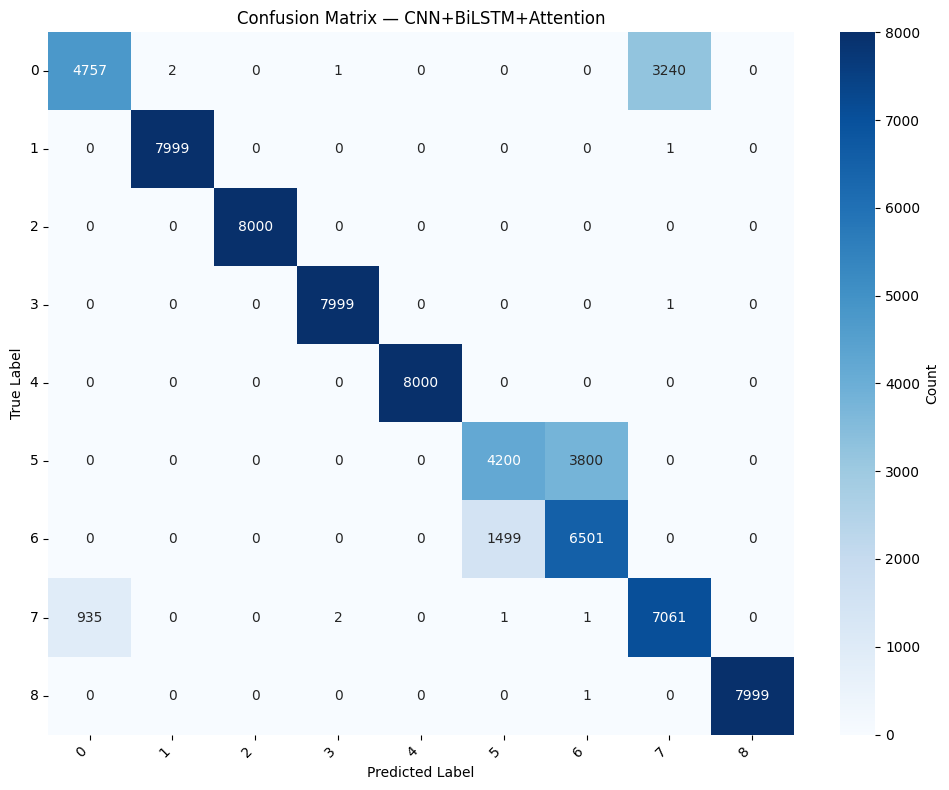

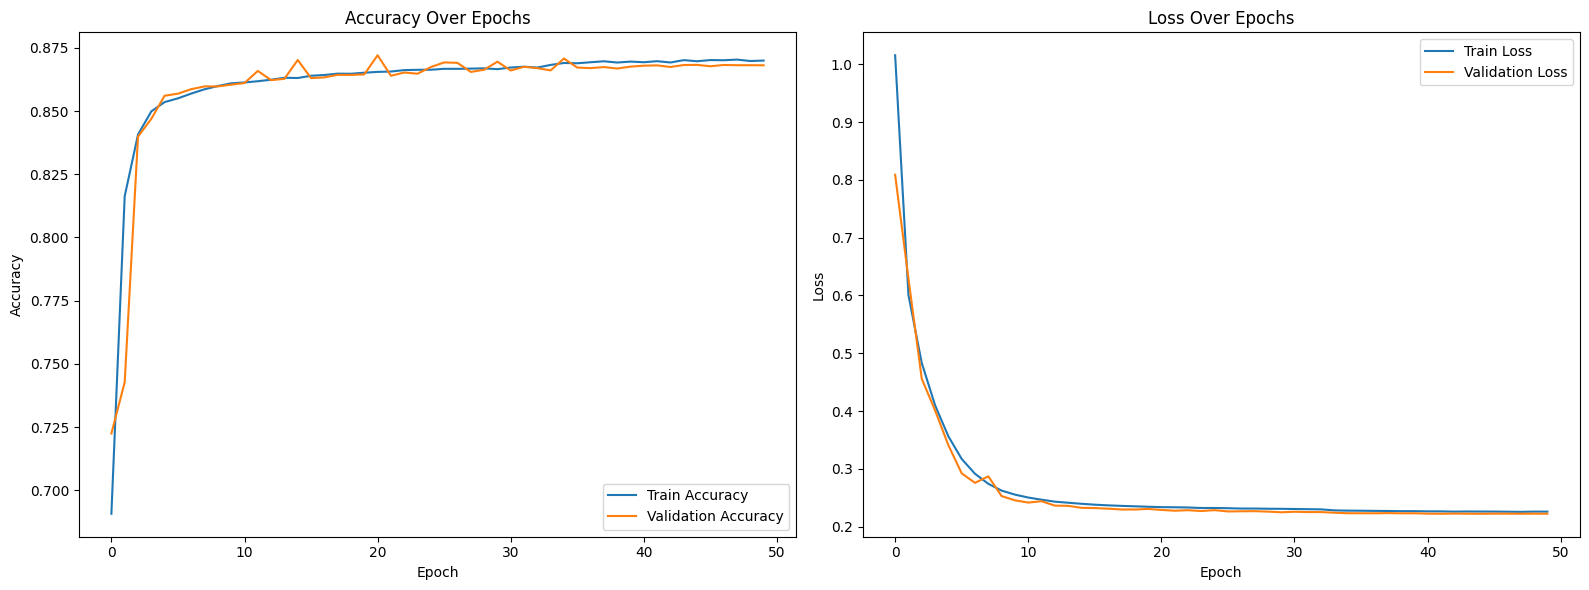

In [17]:
print("\nEvaluating model...")

# === Dự đoán lớp và xác suất ===
y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)
print("Prediction output shape:", y_pred_probs.shape)

# Lấy lớp dự đoán và lớp thật
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)

# === Tính các chỉ số đánh giá ===
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"Recall   : {rec:.4f} ({rec*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

# === Confusion Matrix ===
labels = list(encoder.classes_)  # encoder đã dùng khi encode y
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix — CNN+BiLSTM+Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# === Hàm vẽ biểu đồ training history ===
def plot_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Vẽ lịch sử huấn luyện của mô hình Attention ===
plot_history(history_attn)

# === Dọn bộ nhớ Keras ===
tf.keras.backend.clear_session()


=== Evaluation Phase ===

📊 SGD Evaluation:
----------------------
Accuracy: 0.7824
Precision (weighted): 0.8138
Recall (weighted): 0.7824
F1-Score (weighted): 0.7678

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50      8000
           1       0.88      0.98      0.93      8000
           2       0.99      1.00      1.00      8000
           3       0.95      0.66      0.78      8000
           4       0.74      0.97      0.84      8000
           5       0.60      0.99      0.75      8000
           6       0.97      0.33      0.50      8000
           7       0.57      0.67      0.62      8000
           8       0.99      1.00      1.00      8000

    accuracy                           0.78     72000
   macro avg       0.81      0.78      0.77     72000
weighted avg       0.81      0.78      0.77     72000



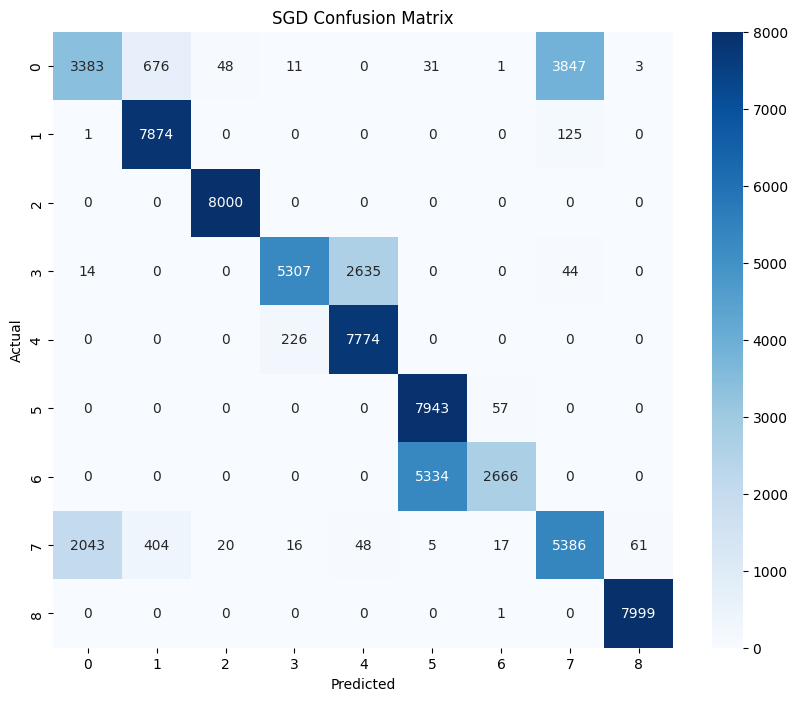


📊 LogReg Evaluation:
----------------------
Accuracy: 0.7927
Precision (weighted): 0.8033
Recall (weighted): 0.7927
F1-Score (weighted): 0.7847

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.43      0.55      8000
           1       0.82      0.99      0.90      8000
           2       0.99      1.00      0.99      8000
           3       0.95      0.67      0.79      8000
           4       0.74      0.97      0.84      8000
           5       0.71      0.55      0.62      8000
           6       0.63      0.78      0.70      8000
           7       0.62      0.74      0.67      8000
           8       0.99      1.00      1.00      8000

    accuracy                           0.79     72000
   macro avg       0.80      0.79      0.78     72000
weighted avg       0.80      0.79      0.78     72000



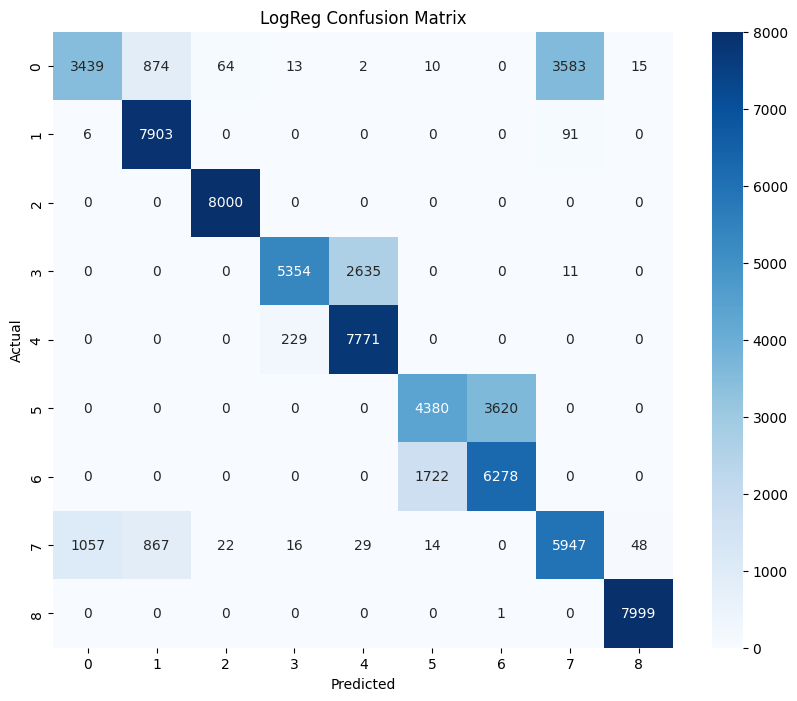


📊 NaiveBayes Evaluation:
----------------------
Accuracy: 0.7064
Precision (weighted): 0.7405
Recall (weighted): 0.7064
F1-Score (weighted): 0.6860

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.50      8000
           1       0.78      0.99      0.87      8000
           2       0.86      1.00      0.93      8000
           3       0.56      0.67      0.61      8000
           4       0.74      0.95      0.83      8000
           5       0.60      0.99      0.75      8000
           6       0.98      0.33      0.50      8000
           7       0.57      0.52      0.54      8000
           8       0.96      0.50      0.65      8000

    accuracy                           0.71     72000
   macro avg       0.74      0.71      0.69     72000
weighted avg       0.74      0.71      0.69     72000



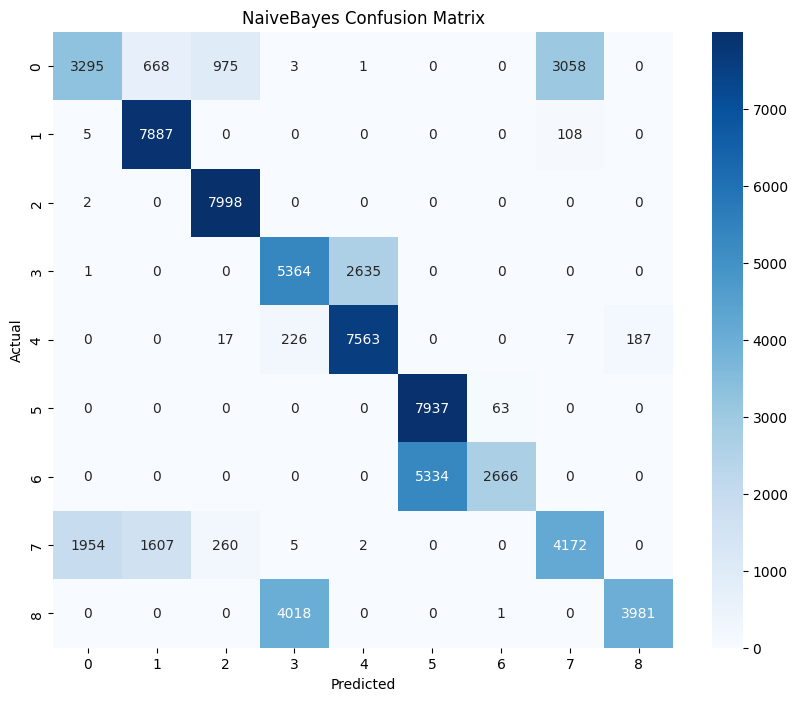


📊 DecisionTree Evaluation:
----------------------
Accuracy: 0.8155
Precision (weighted): 0.8756
Recall (weighted): 0.8155
F1-Score (weighted): 0.7889

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.18      0.29      8000
           1       1.00      0.99      0.99      8000
           2       1.00      1.00      1.00      8000
           3       0.97      0.95      0.96      8000
           4       0.95      0.97      0.96      8000
           5       0.59      0.99      0.74      8000
           6       0.98      0.33      0.50      8000
           7       0.53      0.94      0.68      8000
           8       0.96      1.00      0.98      8000

    accuracy                           0.82     72000
   macro avg       0.88      0.82      0.79     72000
weighted avg       0.88      0.82      0.79     72000



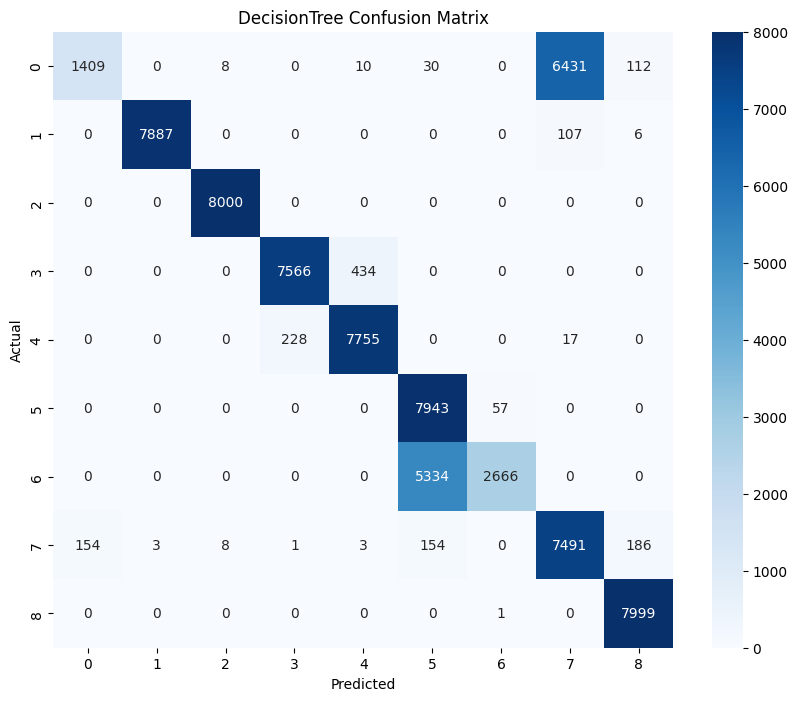


📊 RandomForest Evaluation:
----------------------
Accuracy: 0.8790
Precision (weighted): 0.8902
Recall (weighted): 0.8790
F1-Score (weighted): 0.8757

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      8000
           1       1.00      1.00      1.00      8000
           2       1.00      1.00      1.00      8000
           3       1.00      1.00      1.00      8000
           4       1.00      1.00      1.00      8000
           5       0.82      0.51      0.63      8000
           6       0.64      0.89      0.75      8000
           7       0.71      0.88      0.79      8000
           8       1.00      1.00      1.00      8000

    accuracy                           0.88     72000
   macro avg       0.89      0.88      0.88     72000
weighted avg       0.89      0.88      0.88     72000



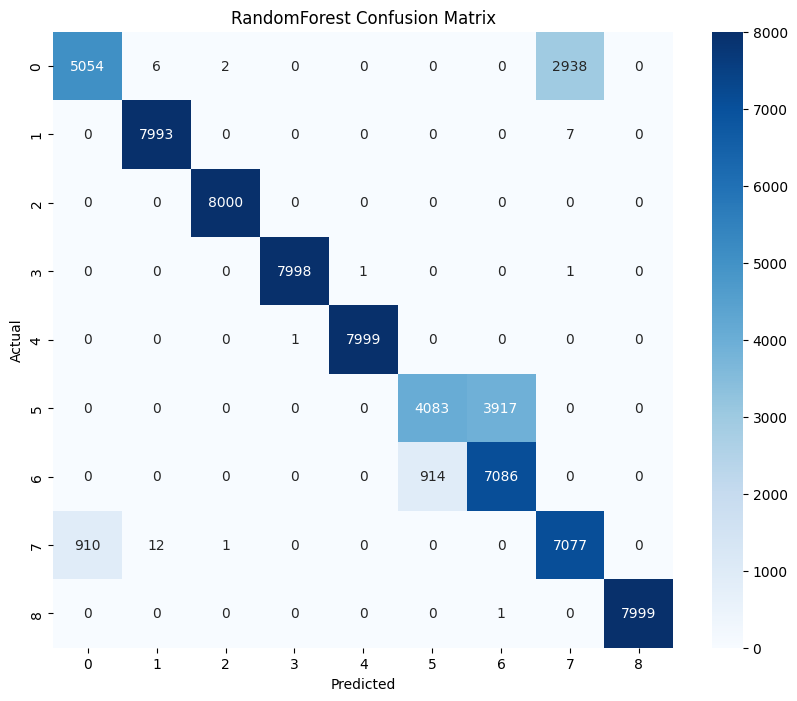

In [18]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    print(f"\n📊 {name} Evaluation:")
    print("----------------------")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (weighted): {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels ,
                yticklabels=labels )
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("=== Evaluation Phase ===")
for name, model in history_ml.items():
    evaluate_model(model, X_test, y_test_ml, name)
    print("="*80)

Final Model Comparison:


,Model,Training Time (s),Accuracy,Precision,Recall,F1
0,SGD,5.819362,0.782389,0.813831,0.782389,0.767761
1,LogReg,246.989963,0.792653,0.803345,0.792653,0.784720
2,NaiveBayes,0.560081,0.706431,0.740505,0.706431,0.686029
3,DecisionTree,2.027650,0.815500,0.875634,0.815500,0.788888
4,RandomForest,10.826311,0.879014,0.890184,0.879014,0.875678


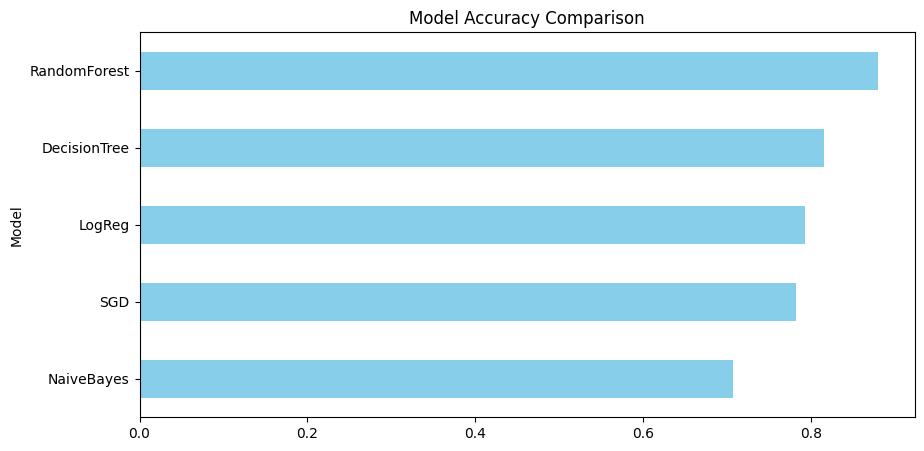

In [19]:
# Compile results
results = []
for name, model in history_ml.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Training Time (s)': training_times[name],
        'Accuracy': accuracy_score(y_test_ml, y_pred),
        'Precision': precision_score(y_test_ml, y_pred, average='weighted'),
        'Recall': recall_score(y_test_ml, y_pred, average='weighted'),
        'F1': f1_score(y_test_ml, y_pred, average='weighted')
    })

# Display as table
results_df = pd.DataFrame(results)
print("Final Model Comparison:")
display(results_df.style.background_gradient(cmap='YlGnBu', subset=['Accuracy', 'F1']))

# Visual comparison
plt.figure(figsize=(10,5))
results_df.set_index('Model')['Accuracy'].sort_values().plot(
    kind='barh',
    title='Model Accuracy Comparison',
    color='skyblue'
)
plt.show()

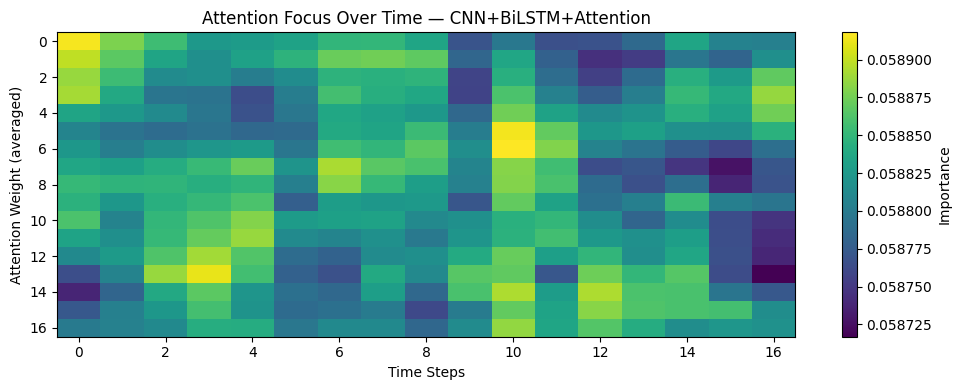

In [20]:
# Lấy đầu ra từ layer BiLSTM trong mô hình hiện tại
bilstm_output = attn_model.get_layer('bilstm').output

# Tạo một MultiHeadAttention mới để trích xuất trọng số
mha_layer = MultiHeadAttention(num_heads=4, key_dim=64, name="mha_view")
attn_out, attn_scores = mha_layer(bilstm_output, bilstm_output, return_attention_scores=True)

# Model phụ để xuất attention map
attention_extractor = Model(inputs=attn_model.input, outputs=attn_scores)

# Lấy attention score cho vài mẫu test đầu tiên
n_samples = 8
attn_scores_test = attention_extractor.predict(X_test_cnn[:n_samples], verbose=0)

# Trung bình các heads → ra (batch, timesteps, timesteps)
attn_mean = np.mean(attn_scores_test, axis=1)

# Biểu đồ heatmap attention
plt.figure(figsize=(10, 4))
plt.imshow(attn_mean.mean(axis=0), cmap='viridis', aspect='auto')
plt.title("Attention Focus Over Time — CNN+BiLSTM+Attention")
plt.xlabel("Time Steps")
plt.ylabel("Attention Weight (averaged)")
plt.colorbar(label='Importance')
plt.tight_layout()
plt.show()


In [21]:
import joblib
import os

save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

# ---------------------------------------------------
# Save Random Forest
# ---------------------------------------------------
if 'rf_model' in globals():
    joblib.dump(rf_model, f"{save_dir}/rf_model.joblib")
    print("Saved: rf_model")

# ---------------------------------------------------
# Save Attention Model (Keras)
# ---------------------------------------------------
if 'attn_model' in globals():
    attn_model.save(f"{save_dir}/attn_model.h5")
    print("Saved: attn_model")

# ---------------------------------------------------
# Save XGB
# ---------------------------------------------------
if 'xgb_model' in globals():
    joblib.dump(xgb_model, f"{save_dir}/xgb_model.joblib")
    print("Saved: xgb_model")

# ---------------------------------------------------
# Save LightGBM
# ---------------------------------------------------
if 'lgbm_model' in globals():
    joblib.dump(lgbm_model, f"{save_dir}/lgbm_model.joblib")
    print("Saved: lgbm_model")

# ---------------------------------------------------
# Save Stacking Model
# ---------------------------------------------------
if 'stacking_model' in globals():
    joblib.dump(stacking_model, f"{save_dir}/stacking_model.joblib")
    print("Saved: stacking_model")

# ---------------------------------------------------
# Save Voting Ensemble
# ---------------------------------------------------
if 'voting_model' in globals():
    joblib.dump(voting_model, f"{save_dir}/voting_model.joblib")
    print("Saved: voting_model")

# ---------------------------------------------------
# Save the Label Encoder
# ---------------------------------------------------
if 'encoder' in globals():
    joblib.dump(encoder, f"{save_dir}/label_encoder.joblib")
    print("Saved: label_encoder")

print("\nAll available models saved successfully!")


Saved: attn_model
Saved: label_encoder

All available models saved successfully!


In [23]:
import joblib
import time
import os

save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

def train_and_save_model(model, model_name, X_train, y_train):
    print(f"Training {model_name}!!!")
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time
    print(f"{model_name} trained in {train_time:.2f} seconds")

    # Save the model after training
    save_path = f"{save_dir}/{model_name}.joblib"
    joblib.dump(model, save_path)
    print(f"Saved {model_name} to: {save_path}\n")

    return model, train_time

history_ml = {}
training_times = {}

for name, model in ml_models.items():
    trained_model, t_time = train_and_save_model(model, name, X_train, y_train_ml)
    history_ml[name] = trained_model
    training_times[name] = t_time

print("All ML models saved successfully!")


Training SGD!!!
SGD trained in 14.31 seconds
Saved SGD to: /content/saved_models/SGD.joblib

Training LogReg!!!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg trained in 250.07 seconds
Saved LogReg to: /content/saved_models/LogReg.joblib

Training NaiveBayes!!!
NaiveBayes trained in 0.56 seconds
Saved NaiveBayes to: /content/saved_models/NaiveBayes.joblib

Training DecisionTree!!!
DecisionTree trained in 2.67 seconds
Saved DecisionTree to: /content/saved_models/DecisionTree.joblib

Training RandomForest!!!
RandomForest trained in 9.81 seconds
Saved RandomForest to: /content/saved_models/RandomForest.joblib

All ML models saved successfully!
